In [3]:
import pandas as pd
import os
import glob
  
  
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "data/*.csv"))
  
all_data = pd.DataFrame()

for f in csv_files:
    df = pd.read_csv(f)
    all_data = pd.concat([all_data, df])   

# Only take matches that are Grand Slams (G)
all_data = all_data[all_data["tourney_level"] == "G"]

# Reset the Index
all_data.reset_index(inplace=True)

# Drop Unused Collumns
collumns_to_drop = [
    'tourney_id', 'index', 'draw_size', 'match_num', 
    'winner_id', 'winner_seed', 'winner_entry', 'winner_hand', 'winner_ht', 
    'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry', 
    'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'w_SvGms',
    'l_SvGms', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'
    ]

all_data.drop(collumns_to_drop, axis=1, inplace=True)

# Drop Rows with Na as values
all_data.dropna(inplace=True)

data_other = all_data[~all_data.winner_name.str.contains("Roger Federer")]
data_other = data_other[~data_other.winner_name.str.contains("Rafael Nadal")]
data_other = data_other[~data_other.winner_name.str.contains("Novak Djokovic")]

data_federer = all_data[all_data['winner_name'] == "Roger Federer"]
data_federer.drop([ 'winner_name' ], axis=1, inplace=True)

data_nadal = all_data[all_data['winner_name'] == "Rafael Nadal"]
data_nadal.drop([ 'winner_name' ], axis=1, inplace=True)

data_djoker = all_data[all_data['winner_name'] == "Novak Djokovic"]
data_djoker.drop([ 'winner_name' ], axis=1, inplace=True)

/usr/lib/python3/dist-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


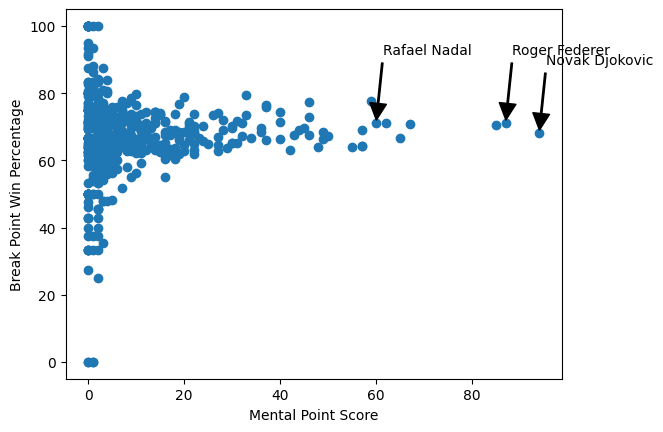

In [4]:
import matplotlib.pyplot as plt
from IPython.display import display

def get_percentage(bpS, bpF):
    '''
    Computes the percentage with the given values.
    
    Args:
        bpS (int): break points saved
        bpF (int): break points faced

    Returns:
        The percentage as a float
    '''

    if bpF == 0:
        return 0
    else:
        return round((float(bpS) / float(bpF)), 4) * 100


def add_mental_points_col(df, names):
    '''
    Computes mental points of each score and adds it into another collumn.
    
    Args:
        df (pd.DataFrame): The data frame with the tennis data
        names (list(str)): The list of names of all tennis players

    Returns:
        The new dataframe.
    '''

    # Add the new collumn
    df["mental_score"] = 0

    # Iterate through all the names
    for name in names:
        # Get the data of that name
        data_name = all_data[all_data['winner_name'] == name]
        mental_score = 0

        # For every match score, comput the mental score
        for _, row in data_name.iterrows():
            score = row['score']
            
            if score.count('-') == 5:
                mental_score = mental_score + 2
            
            if score.rsplit("-",1).pop() == "6":
                mental_score = mental_score + 4
            
            mental_score = int(mental_score + score.count("7-")/2)
                
        # Add the mental score
        df.loc[[name],['mental_score']] = mental_score
    

def annotate_plot(ax, df, names):
    '''
    Annotate the given plot and label the names from the given dataframe.
    
    Args:
        ax (matplotlib.axes.Axes): The axis of the plot
        df (pd.DataFrame): The data
        names (list(str)): The list of names of all tennis players to annotate
    '''
    for name in names:
        ax.annotate(name, (int(df.loc[[name], ["mental_score"]].values[0]), int(df.loc[[name], ["percentage"]].values[0])), xytext=(5,50), textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05, width=1))

# Group the data by winner name and add all the break points
mental_df = all_data[['winner_name', 'w_bpSaved', 'w_bpFaced']].groupby('winner_name').sum()

# Add a percentage collumn with the breakpoint percentage
mental_df['percentage'] = mental_df.apply(lambda x: get_percentage(x['w_bpSaved'], x['w_bpFaced']), axis=1)

# Add a mental points collumn with the mental point scores
add_mental_points_col(mental_df, list(mental_df.index))

# Plot the scatterplot
fig, ax = plt.subplots()
ax.scatter(mental_df['mental_score'], mental_df['percentage'])
ax.set_xlabel('Mental Point Score')
ax.set_ylabel('Break Point Win Percentage')
annotate_plot(ax, mental_df, ["Roger Federer", "Novak Djokovic", "Rafael Nadal"])
plt.show()

# def get_year_score(name):
#     name_df = all_data[all_data['winner_name'] == name]
#     new_df = pd.DataFrame()
#     new_df['tourney_date'] = 0
#     new_df['score'] = 0
#     for _, row in name_df.iterrows():

#         mental_score = 0
#         score = row['score']
            
#         if score.count('-') == 5:
#             mental_score = mental_score + 2
            
#         if score.rsplit("-",1).pop() == "6":
#             mental_score = mental_score + 4
        
#         mental_score = int(mental_score + score.count("7-")/2)
    
#         new_df = new_df.append([{'tourney_date':int(str(row['tourney_date'])[0:4]), 'score':mental_score}], ignore_index=True)

#     return new_df[['tourney_date', 'score']].groupby('tourney_date').sum()

# def get_year_score_avg_player():
#     name_df = all_data[(all_data['winner_name'] != "Roger Federer") & (all_data['winner_name'] != "Rafael Nadal") & (all_data['winner_name'] != "Novak Djokovic") ]
#     all_names = list(name_df['winner_name'])
#     all_dfs = []

#     for name in all_names:
#         all_dfs.append(get_year_score(name))

#     # for _, row in name_df.iterrows():

#     #     mental_score = 0
#     #     score = row['score']
            
#     #     if score.count('-') == 5:
#     #         mental_score = mental_score + 2
            
#     #     if score.rsplit("-",1).pop() == "6":
#     #         mental_score = mental_score + 4
        
#     #     mental_score = int(mental_score + score.count("7-")/2)
    
#     #     new_df = new_df.append([{'tourney_date':int(str(row['tourney_date'])[0:4]), 'score':mental_score}], ignore_index=True)

#     # return new_df[['tourney_date', 'score']].groupby('tourney_date').sum()



# mental_over_years_fed = get_year_score('Roger Federer')
# mental_over_years_rafa = get_year_score('Rafael Nadal')
# mental_over_years_novak = get_year_score('Novak Djokovic')

# fig = plt.figure()

# for frame in [mental_over_years_fed, mental_over_years_novak, mental_over_years_rafa]:
#     plt.plot(frame.index, frame['score'])

# plt.xlim(2002, 2021)
# plt.show()
